In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
path = "./data1"
all_files = glob.glob(path + "/*.csv")

def rank(path):
    return int(path.split('/')[2].split('.')[0][5:])

all_files = sorted(all_files, key=rank)

In [3]:
li = []
# read in the first 30 csv files
pid_base = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None)
    df['pid'] = df['pid'] + pid_base
    li.append(df)
    pid_base += 1000

dfs = pd.concat(li, axis=0, ignore_index=True)

In [4]:
# def cos_sim(a, b):
#     dot = np.dot(a, b)
#     a_norm = np.linalg.norm(a)
#     b_norm = np.linalg.norm(b)
#     return dot / (a_norm * b_norm)

In [5]:
dfs.tail()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
2076002,30999,42,Natalie Cole,spotify:track:4Dno5w6kIkz9qJM9FqL61o,spotify:artist:5tTsrGPwQRWUsHR2Xf7Ke9,Medley: For Sentimental Reasons / Tenderly / A...,spotify:album:78qajwwkI8eOt1DrnUOtuL,452746,Unforgettable: With Love
2076003,30999,43,Frank Sinatra,spotify:track:2PRq7qR6hT5FWfagC4wFfm,spotify:artist:1Mxqyy3pSjf8kZZL4QVxS0,Don'cha Go 'Way Mad,spotify:album:7B45fvRtEecfSqKqUYXh6X,191626,Sinatra And Swingin' Brass
2076004,30999,44,Quincy Jones,spotify:track:3oSFAA9uFbtokLDyLTMbX6,spotify:artist:3rxIQc9kWT6Ueg4BhnOwRK,You Turned The Tables On Me,spotify:album:4Ku1ZZXHwzJiWqm7itvuZI,152026,I Dig Dancers
2076005,30999,45,Stevie Wonder,spotify:track:4UjeXiBihLSc7WFECGFkmJ,spotify:artist:7guDJrEfX3qb6FEbdPA5qi,Knocks Me Off My Feet,spotify:album:2HVx2tiZnLX8xeaUthed1e,216456,Songs In The Key Of Life
2076006,30999,46,Common,spotify:track:148LD1wYrUQR3cluHlartB,spotify:artist:2GHclqNVjqGuiE5mA7BEoc,Changes,spotify:album:6wl2laSmw3sucFUwRlqAP2,238200,Universal Mind Control


In [6]:
dic = dict()

In [7]:
# construct dictionary where key is playlist id and value is a list of track_uris that are in this playlist
for i, row in dfs.iterrows():
    if row['pid'] in dic:
        dic[row['pid']].append(row['track_uri'])
    else:
        dic[row['pid']] = [row['track_uri']]

In [8]:
# define cosine similarity to measure similaritiy between playlists
def cos_sim1(dic, a, b):
    a_tracks = set(dic[a])
    b_tracks = set(dic[b])
    inter = len(a_tracks.intersection(b_tracks))
    a_norm = np.sqrt(len(a_tracks))
    b_norm = np.sqrt(len(b_tracks))
    
    return inter / (a_norm * b_norm)

In [9]:
# base=1
# res = []
# base_tracks = set(dic[base])
# num_base = len(base_tracks)
# for p, s in sim_list:
#     p_tracks = set(dic[p])
#     diff = list(p_tracks.difference(base_tracks))
#     cur_diff = num_base - len(res) 
    
#     if cur_diff > 0:
#         num_candi = len(diff)
        
#         if num_candi <= cur_diff: 
#             res.extend(diff)
#         else:
#             res.extend(diff[:cur_diff])
#             break     
#     else:
#         break

In [10]:
def get_sims_for_track(dic, base):
    sim_list = []
    for key in dic.keys():
        sim = cos_sim1(dic, base, key)
        sim_list.append([key, sim])
    sim_list = sorted(sim_list, key=lambda x: -x[1])
    sim_list = sim_list[1:]
    return sim_list


def recommend_playlist(dic, base):
    """
    recommend songs from the most similar playlists in terms of cosine similarity
    """
    res = []
    base_tracks = set(dic[base])
    num_base = len(base_tracks)
    
    # get a list of most similar playlists given the base playlist
    sim_list = get_sims_for_track(dic, base)
    for p, s in sim_list:
        p_tracks = set(dic[p])
        diff = list(p_tracks.difference(base_tracks))
        
        # recommend n songs for each playlist, where n is the original playlist size
        cur_diff = num_base - len(res) 

        if cur_diff > 0:
            num_candi = len(diff)

            if num_candi <= cur_diff: 
                res.extend(diff)
            else:
                res.extend(diff[:cur_diff])
                break     
        else:
            break
            
    return res


In [11]:
def eval_playlist(test_tracks, recommended_tracks):
    # r-precision evaluation
    test = set(test_tracks)
    pred = set(recommended_tracks)
    res = list(test & pred)
    return len(res) / len(test)


def recommend_eval(dic,split_ratio):
    res = []
    
    for base in dic.keys():
        ratio = int(split_ratio*len(dic[base]))
        
        dic_temp = dic.copy()
        
        dic_temp[base] = dic[base][:ratio]
        
        recommended_tracks = recommend_playlist(dic_temp, base)
        r_precision = eval_playlist(dic[base][ratio:], recommended_tracks)
        res.append(r_precision)
    return res

In [12]:
del dfs

In [13]:
# evaluation file
df1 = pd.read_csv('songs0.csv')

In [14]:
# construct dictionary where key is playlist id and value is a list of track_uris that are in this playlist
dic1 = {}
for i, row in df1.iterrows():
    if row['pid'] in dic1:
        dic1[row['pid']].append(row['track_uri'])
    else:
        dic1[row['pid']] = [row['track_uri']]


res = recommend_eval(dic1, 0.8)

In [18]:
np.mean(res)

0.04403777404239364

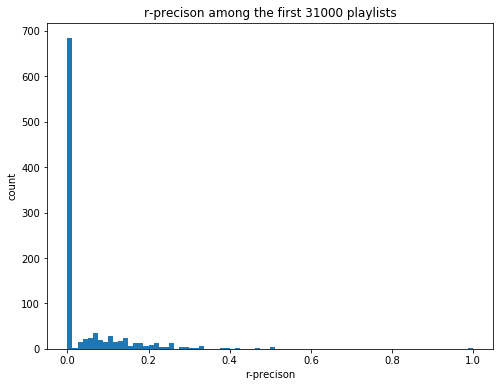

In [15]:
plt.figure(figsize=(8,6))
plt.title('r-precison among the first 31000 playlists')
plt.xlabel('r-precison')
plt.ylabel('count')
plt.hist(res, bins=80)
plt.show()

In [16]:
res1 = np.take(res, np.nonzero(res)[0])

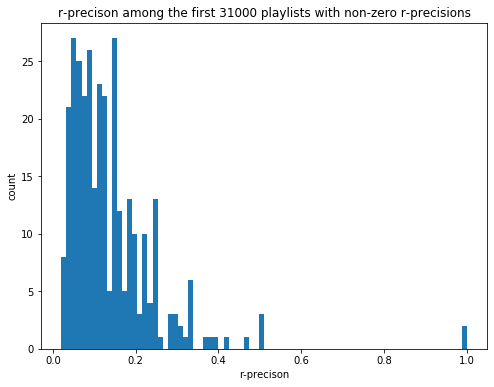

In [17]:
plt.figure(figsize=(8,6))
plt.title('r-precison among the first 31000 playlists with non-zero r-precisions')
plt.xlabel('r-precison')
plt.ylabel('count')
plt.hist(res1, bins=80)
plt.show()